In [ ]:
# ======= Importando bibliotecas ======= #
# gerais
import pandas as pd
import numpy as np

# NLP, deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from my_nlp_library import MyTokenizer
from sklearn.manifold import TSNE

# visualização
import matplotlib.pyplot as plt
from tqdm import tqdm # This will make a progress bar for us
import plotly.express as px

## 1. Embeddings
### 1.1 Dataset

In [71]:
# Carregar o dataset e modelo
df = pd.read_csv('data/arxiv3.csv')

df.head()

Unnamed: 0                                              title  \
0           5  Bosonic characters of atomic Cooper pairs acro...   
1          19  Measurement of the Hadronic Form Factor in D0 ...   
2          24  Spectroscopic Properties of Polarons in Strong...   
3          29  Tuning correlation effects with electron-phono...   
4          32  Convergence of the discrete dipole approximati...   

                                             authors  \
0                           Y. H. Pong and C. K. Law   
1          The BABAR Collaboration, B. Aubert, et al   
2  A. S. Mishchenko (1 and 2) and N. Nagaosa (1 a...   
3                       J.P.Hague and N.d'Ambrumenil   
4  Maxim A. Yurkin, Valeri P. Maltsev, Alfons G. ...   

                                            abstract  \
0    We study the two-particle wave function of p...   
1    The shape of the hadronic form factor f+(q2)...   
2    We present recent advances in understanding ...   
3    We investigate the effect of tuning the phon...   
4    We performed a rigorous theoretical converge...   

                           categories update_date  
0                   cond-mat.mes-hall  2015-05-13  
1                              hep-ex  2015-06-30  
2  cond-mat.str-el cond-mat.stat-mech  2015-05-13  
3                     cond-mat.str-el  2015-05-13  
4      physics.optics physics.comp-ph  2022-03-31

In [73]:
# Carregando os embeddings do GloVe
def load_glove_vectors(glove_file):
    glove_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(val) for val in values[1:]], dtype=torch.float32)
            glove_vectors[word] = vector
    return glove_vectors

glove_file = "data/glove.6B.300d.txt" 
glove_vectors = load_glove_vectors(glove_file)


def get_vocabulary_from_glove(glove_vectors):
    vocab = dict()
    inverse_vocab = list()
    vocab["<PAD>"] = 0
    inverse_vocab.append("<PAD>")
    vocab["<UNK>"] = 1
    inverse_vocab.append("<UNK>")
    for word, vector in glove_vectors.items():
        vocab[word] = len(inverse_vocab)
        inverse_vocab.append(word)
    return vocab, inverse_vocab

vocab, inverse_vocab = get_vocabulary_from_glove(glove_vectors)

In [74]:
embedding_dim = 300 
vocab_size = len(glove_vectors) + 2
embedding_glove = nn.Embedding(vocab_size, embedding_dim)

for idx, word in enumerate(inverse_vocab[2:]):
    i = idx + 2
    embedding_glove.weight[idx].data = glove_vectors[word]

print("Embedding layer created with shape:", embedding_glove.weight.shape)

Embedding layer created with shape: torch.Size([400002, 300])


In [75]:
embedding_glove.weight.shape

torch.Size([400002, 300])

In [76]:
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer, embedding):
        self.texts = texts
        self.tokenizer = tokenizer
        self.embedding_layer = embedding

    def __len__(self):
        return len(self.texts)
    

    def __getitem__(self, idx):
        text = self.texts[idx]
        tokens = self.tokenizer(text)
        
        tokens = np.array(tokens)
        mask = tokens > 1
        x = torch.tensor(tokens)
        x = self.embedding_layer(x)
        pooled = torch.mean(x[mask], dim=0)
        tensor = torch.tensor(pooled)
        return tensor

In [77]:
class Transformador( nn.Module ):
    def __init__(self, n_inputs, n_hidden):
        super().__init__()
        self.layer1 = nn.Linear(n_inputs, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_inputs)

    def forward(self, x):
        h = self.layer1(x)
        z = self.layer2(h)
        return z, h
    
        

In [115]:
class PreparaTexto( nn.Module ):
    def __init__(self, tokenizer, embedding_layer):
        super().__init__()
        self.tokenizer = tokenizer
        self.embedding_layer = embedding_layer

    def forward(self, x):
        # Tokenize
        tokens = self.tokenizer(x)
        tokens = np.array(tokens)
        mask = tokens > 1
        x = torch.tensor(tokens)
        x = self.embedding_layer(x)
        pooled = torch.mean(x[mask], dim=0)
        return pooled

### 1.3 Treinamento

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\livia\AppData\Local\Temp\ipykernel_16792\4260337076.py:20: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

100%|██████████| 50/50 [05:38<00:00,  6.77s/it]


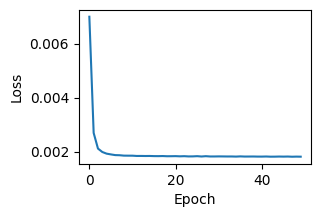

In [ ]:
X = df['abstract']


tokenizer = MyTokenizer(sentence_length=800, case_sensitive=False, vocab=vocab, inverse_vocab=inverse_vocab)

dataset = TextDataset(list(X), tokenizer, embedding_glove)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = Transformador(
    n_inputs=embedding_dim,
    n_hidden=200
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # lr is the learning rate - this is our alpha

criterion = nn.MSELoss()
# And now, a loop that is equal for everyone:
losses = []
for epoch in tqdm(range(50)):
    epoch_loss = 0
    for batch in dataloader:
        X_batch = batch

        optimizer.zero_grad()
        output, _ = model(X_batch)
        
        loss = criterion(output, X_batch)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dataloader))

plt.figure(figsize=(3,2))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() 

## 2. Visualização 

In [100]:

tuned_embeddings = []
pre_trained_embeddings = []
dataloader_no = DataLoader(dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for batch in dataloader_no:
        X_batch = batch
        _, output= model(X_batch)
        tuned_embeddings.append(output.detach().numpy())
        pre_trained_embeddings.append(X_batch.detach().numpy())

C:\Users\livia\AppData\Local\Temp\ipykernel_16792\4260337076.py:20: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [101]:
embeddings_matrix = torch.tensor(np.concatenate(tuned_embeddings, axis=0))
pre_trained_matrix = torch.tensor(np.concatenate(pre_trained_embeddings, axis=0))

In [ ]:
# save matrix in a file
torch.save(embeddings_matrix, 'data/embeddings_matrix.pt')


In [112]:
def get_cluster(matrix ):
    X_viz = matrix.detach().numpy()
    tsne = TSNE(n_components=2, perplexity=3)
    X_proj = tsne.fit_transform(X_viz)

    px.defaults.width = 1500
    px.defaults.height = 1000

    


    df_viz = pd.DataFrame(X_proj, columns=['x', 'y'])
    df_viz['title'] = df['title']
    df_viz['abstract'] = df['abstract']

    # df_viz['category'] = df['categories']


    fig = px.scatter(df_viz, x='x', y='y',   hover_data=['title'])
    fig.update_traces(textposition='top center')
    
    return fig 



In [113]:
fig1 = get_cluster(embeddings_matrix)

In [116]:
fig1.update_layout(title='Cluster de embeddings treinados')
fig1.show()

In [114]:
fig2 = get_cluster(pre_trained_matrix)

In [ ]:
fig2.update_layout(title='Cluster de embeddings pré-treinados')

fig2.update_traces(marker=dict(color='red'))
fig2.show()

In [140]:
embeddings_matrix.shape
pre_trained_matrix.shape

torch.Size([20126, 300])

# Sistema de busca

In [200]:
preparador = PreparaTexto(tokenizer, embedding_glove)
from sklearn.preprocessing import normalize



def predict(query, embeddings_matrix, model, preparador):
    query_embedding = preparador(query)
    query_processed = model(query_embedding)[1].detach().numpy() 

    query_processed_ = normalize(query_processed.reshape(1, -1))

    embeddings_matrix_ = normalize(embeddings_matrix)   
    
    R = embeddings_matrix_ @ query_processed_.T

    df_ = df.copy()
    relevance = R.flatten()
    df_["relevance"] = relevance

    df_filtered = df_[relevance > 0.24]
    df_final = df_filtered.sort_values("relevance", ascending=False)

    # Selecionar colunas de interesse
    df_final = df_final[['title', 'abstract', 'relevance']]

    # print the top 10 abstracts
    tam = min(10, len(df_final))
    for i in range(tam):
        print(df_final['abstract'].iloc[i])
        print('-----------------------------------')
        
    return df_final.head(10)



In [184]:
query = "neural network"
df_final = predict(query, embeddings_matrix, model, preparador)
df_final.head(10)

  This paper considers the problem of efficiently transmitting quantum states
through a network. It has been known for some time that without additional
assumptions it is impossible to achieve this task perfectly in general --
indeed, it is impossible even for the simple butterfly network. As additional
resource we allow free classical communication between any pair of network
nodes. It is shown that perfect quantum network coding is achievable in this
model whenever classical network coding is possible over the same network when
replacing all quantum capacities by classical capacities. More precisely, it is
proved that perfect quantum network coding using free classical communication
is possible over a network with $k$ source-target pairs if there exists a
classical linear (or even vector linear) coding scheme over a finite ring. Our
proof is constructive in that we give explicit quantum coding operations for
each network node. This paper also gives an upper bound on the number of
cla

title  \
15846  General Scheme for Perfect Quantum Network Cod...   
3732   Optimal network topologies for information tra...   
12628  A "Cellular Neuronal" Approach to Optimization...   
16595  Scaling properties in spatial networks and its...   
12770                 On network coding for sum-networks   
15617  Passive network tomography for erroneous netwo...   
7383   Sensing Models and Its Impact on Network Cover...   
274    Comparing Robustness of Pairwise and Multiclas...   
16230        Evolutionary Subnetworks in Complex Systems   
20022                      Resonant guided wave networks   

                                                abstract  relevance  
15846    This paper considers the problem of efficien...   0.432372  
3732     This work clarifies the relation between net...   0.428473  
12628    The Hopfield-Tank (1985) recurrent neural ne...   0.400596  
16595    Empirical studies on the spatial structures ...   0.390031  
12770    A directed acyclic network is considered whe...   0.388112  
15617    Passive network tomography uses end-to-end o...   0.371907  
7383     Network coverage of wireless sensor network ...   0.371584  
274      Noise, corruptions and variations in face im...   0.370652  
16230    Links in a practical network may have differ...   0.335708  
20022    A resonant guided wave network (RGWN) is an ...   0.335341

In [201]:
query = "cooper pair box"
df_final = predict(query, embeddings_matrix, model, preparador)
df_final.head(10)

  We present a study of adiabatic Cooper pair pumping in one dimensional array
of Cooper pair boxes. We do a detailed theoretical analysis of an
experimentally realizable stabilized charge pumping scheme in a linear array of
Cooper pair boxes. Our system is subjected to synchronized flux and voltage
fields and travel along a loop which encloses their critical ground state of
the system in the flux-voltage plane. The locking potential in the sine-Gordon
model slides and changes its minimum which yields the Cooper pair pumping. Our
analytical methods are the Berry phase analysis and Abelian bosonization
studies.

-----------------------------------
  Ultrathin amorphous Bi films, patterned with a nano-honeycomb array of holes,
can exhibit an insulating phase with transport dominated by the incoherent
motion of Cooper pairs of electrons between localized states. Here we show that
the magnetoresistance of this Cooper pair insulator phase is positive and grows
exponentially with decreasing 

title  \
4216   Adiabatic Cooper-Pair Pumping in a Linear Arra...   
14971  Observation of Giant Positive Magnetoresistanc...   
0      Bosonic characters of atomic Cooper pairs acro...   
2819   Effect of the equilibrium pair separation on c...   
19851  "Moth-eaten effect" driven by Pauli blocking, ...   
1287   Closure Relations for Electron-Positron Pair-S...   
12804  Fluxonium: single Cooper pair circuit free of ...   
17714         Localised eigenfunctions in Seba billiards   

                                                abstract  relevance  
4216     We present a study of adiabatic Cooper pair ...   0.425879  
14971    Ultrathin amorphous Bi films, patterned with...   0.350074  
0        We study the two-particle wave function of p...   0.345456  
2819     A simple pair potential, which equilibrium p...   0.329823  
19851    We extend the well-known Cooper's problem be...   0.282288  
1287     We present recipes to diagnose the fireball ...   0.273396  
12804    The promise of single Cooper pair quantum ci...   0.272862  
17714    We describe some new families of quasimodes ...   0.244352

In [202]:
query = "wolf"
df_final = predict(query, embeddings_matrix, model, preparador)
df_final.head(10)

  Electronic band structure and energetic stability of two types of and
oriented silicon nanowires in beta-Sn phase with the surface terminated by
hydrogen atoms were studied using density functional theory. It was found that
beta-Sn nanowires are metastable with zero band gap against to alpha-diamond
nanowires. The relative energy of the studied wires tends to the energy of the
bulk silicon crystal in beta-Sn phase.

-----------------------------------
  Aims: We investigate the massive stellar content of the nearby dwarf
irregular Wolf-Rayet galaxy IC 4662, and consider its global star forming
properties in the context of other metal-poor galaxies, the SMC, IC 10 and NGC
1569. Methods: Very Large Telescope/FORS2 imaging and spectroscopy plus
archival Hubble Space Telescope/ACS imaging datasets permit us to spatially
identify the location, number and probable subtypes of Wolf-Rayet stars within
this galaxy. We also investigate suggestions that a significant fraction of the
ionizing ph

title  \
13192  Metallic beta-phase silicon nanowires: structu...   
9730   On the massive star content of the nearby dwar...   

                                                abstract  relevance  
13192    Electronic band structure and energetic stab...   0.254209  
9730     Aims: We investigate the massive stellar con...   0.246872